# Problem 2

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy
import random
import matplotlib.pyplot as plt

# for the recommendation - Implicit Collaborative Filtering
import implicit

In [2]:
# load the dataset
data = pd.read_excel('Online Retail.xlsx')

# look at top 5 rows
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Preprocessing

In [5]:
# Remove the duplicate rows
data = data[~data.duplicated()]

#### Handleing with canceled orders

Split into two tables, puchased and canceled

In [6]:
canceled = data[data['InvoiceNo'].str.startswith('C') == True]
print(len(canceled))
canceled.head()

9251


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [7]:
purchased = data[data['InvoiceNo'].str.startswith('C') != True]
print(len(purchased))
purchased.head()

527390


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
# We corrected the quantity with cancelling order (['InvoiceNo'].str.startswith('C'))
# The returned items must have the same CustomerID, same StockCode, and same UnitPrice
# We only combine the quantity information for the canceled orders and omit other information.
corrected_qty = pd.merge(purchased, canceled, on=['CustomerID','StockCode','UnitPrice'], how='left')
corrected_qty['Quantity_y'] = corrected_qty['Quantity_y'].fillna(0)
corrected_qty['Quantity'] = corrected_qty['Quantity_x'] + corrected_qty['Quantity_y']
corrected_qty['Quantity'] = corrected_qty['Quantity'].astype(int)

In [9]:
# Reconstuct the df and rename df
df = corrected_qty[['InvoiceNo_x', 'StockCode', 'Description_x', 'Quantity', 'InvoiceDate_x', 'UnitPrice', 'CustomerID', 'Country_x']].copy()
new_names = {'InvoiceNo_x':'InvoiceNo', 'Description_x':'Description', 'InvoiceDate_x': 'InvoiceDate','Country_x':'Country'}
df.rename(columns = new_names, inplace= True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
# Check the distribution of quantity
df.Quantity.describe()

count    531702.000000
mean          9.708376
std          51.935427
min       -9600.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       12540.000000
Name: Quantity, dtype: float64

In [11]:
# Check the distribution of unit price
df.UnitPrice.describe()

count    531702.000000
mean          3.905680
std          45.935139
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [12]:
# Keep only those transactions which Quantity > 0
df = df[df['Quantity'] > 0]
# Unit price > 0
df = df[df['UnitPrice'] > 0]

In [13]:
# postage is irrelevent of purchasing
df = df[(df['StockCode'] != "DOT")]
df = df[(df['StockCode'] != "POST")]
df = df[df['StockCode'] != "C2"]

# Fees, manual, adjusted debts, bank charges, carriage, and gift voucher are irrelevent 
df = df[df['StockCode'] != "AMAZONFEE"]
df = df[df['StockCode'] != "M"]
df = df[df['StockCode'] != "m"]
df = df[df['StockCode'] != "B"]
df = df[df['StockCode'] != "BANK CHARGES"]
df = df[df['Description'].str.contains("Carriage") != True]
df = df[df['Description'].str.contains("Gift Voucher") != True]

In [14]:
# Regex of Description
df['Description'] = df['Description'].str.replace(r'[\!\%\[\]\,\。\*\.]','')
df['Description'] = df['Description'].str.replace('  ', ' ') # double space to single space
df['Description'] = df['Description'].str.upper() # upper case
df['Description'] = df['Description'].str.strip() # remove spaces at the end/beginning of the strings

In [15]:
# Assume when CustomerID = NA, it means the buyers buy things without registration.  
# The total NA in CustomerID is around 25%. 
# We want to avoid neglecting 25% of data, especially they have other useful information in other columns.
# We assume they are not related to any existing customers and they are all different.
# So, we assign them simply with 'InvoiceNo' because 'InvoiceNo' has different digits (6) from 'CustomerID' (5)
# Since the original 'CustomerID' is stored in floating point, we convert it into int for convenience
# The data is prepared for the recommendations 

df_keep_no_CustomerID = df.copy()
df_keep_no_CustomerID['CustomerID'].fillna(df_keep_no_CustomerID['InvoiceNo'], inplace=True)
df_keep_no_CustomerID['CustomerID'] = df_keep_no_CustomerID['CustomerID'].astype(int)

In [16]:
# For RFM analysis, we don't care about people who don't register because we only care about the "members".
df.dropna(subset=['CustomerID'], inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int)

## Little Findings

In [17]:
# Check the number of unique transactions
df.InvoiceNo.nunique()

18166

In [18]:
# Check the unique stock ids
df.StockCode.nunique()

3644

In [19]:
# top 10 stock ids that sold the most
df.StockCode.value_counts().head(10)

22423     2012
85123A    2000
85099B    1632
84879     1387
47566     1359
20725     1302
22720     1183
22197     1175
23203     1076
20727     1066
Name: StockCode, dtype: int64

In [20]:
# Check the region
df.Country.value_counts(normalize=True)

United Kingdom          0.891794
Germany                 0.022723
France                  0.020334
EIRE                    0.018163
Spain                   0.006149
Netherlands             0.005946
Belgium                 0.004959
Switzerland             0.004640
Portugal                0.003626
Australia               0.002847
Norway                  0.002654
Italy                   0.001978
Channel Islands         0.001911
Finland                 0.001664
Cyprus                  0.001538
Sweden                  0.001088
Austria                 0.000988
Denmark                 0.000936
Japan                   0.000854
Poland                  0.000828
Israel                  0.000630
Unspecified             0.000620
Singapore               0.000553
Iceland                 0.000468
Canada                  0.000386
Greece                  0.000365
Malta                   0.000303
United Arab Emirates    0.000172
USA                     0.000172
European Community      0.000147
RSA       

##### Findings: More than 90% of the data are from the UK because the retailer is based in the UK.

# (1) Customer Segmentation

## Create RFM Table

In [21]:
# Convert InvoiceDate to Date
df['InvoiceDate'] = df['InvoiceDate'].dt.date
print(min(df['InvoiceDate']), max(df['InvoiceDate'])) # date range of data

2010-12-01 2011-12-09


Use 2011-12-10 as snapshot date!

- For Recency: Calculate the number of days between snapshot date and date of last purchase for each customer.
- For Frequency: Calculate the number of orders made for each customer.
- For Monetary: Calculate the total purchase amount for each customer.

In [22]:
# Create a new column to calculate the difference between the record and the sanpshot date
df['DateDifference'] =  dt.date(2011, 12, 10) - df['InvoiceDate']
df['DateDifference'] = df['DateDifference'].dt.days

In [23]:
# Create a new column to calculate the price (Quantity * UnitPrice) of each row
df['Price'] = df['Quantity'] * df['UnitPrice']

In [24]:
# Create RFM talbe
rfm = df.groupby('CustomerID').agg({'DateDifference': np.min,
                                   'InvoiceNo': pd.Series.nunique,
                                   'Price': np.sum})

In [25]:
# Update the column name
rfm.columns=['Recency', 'Frequency', 'Monetary']

In [26]:
# For most use cases, people usually look at one year data
rfm = rfm[rfm['Recency'] <= 365]

In [27]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4248 entries, 12347 to 18287
Data columns (total 3 columns):
Recency      4248 non-null int64
Frequency    4248 non-null int64
Monetary     4248 non-null float64
dtypes: float64(1), int64(2)
memory usage: 132.8 KB


## We'll do 5x5x5 RFM analysis

In [28]:
# Get the sense of the distribution
rfm.quantile([.2, .4, .6, .8]).to_dict()

{'Recency': {0.2: 13.0, 0.4: 32.0, 0.6: 71.0, 0.8: 172.60000000000036},
 'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 6.0},
 'Monetary': {0.2: 251.94600000000003,
  0.4: 487.8940000000001,
  0.6: 922.174,
  0.8: 2028.7000000000019}}

#### For the convenience of marketers, we can choose the grouping method as follows:

- Recency:

|  Days  | R-score |
|:------:|:-------:|
| 0-14   |    5    |
| 15-30  |    4    |
| 31-60  |    3    |
| 60-180 |    2    |
| > 180  |    1    |

- Frequency

|Frequency| F-score |
|:-------:|:-------:|
|  > 6    |    5    |
|  5 - 6  |    4    |
|  3 - 4  |    3    |
|    2    |    2    |
|    1    |    1    |


- Monetary

| Monetary   | M-score |
|:----------:|:-------:|
|   >2000    |    5    |
| (1000-2000]|    4    |
| (500-1000] |    3    |
| (250-500]  |    2    |
| (0, 250]   |    1    |

In [29]:
def r_score(x):
    if x <= 14:
        return 5
    elif x <= 30:
        return 4
    elif x <= 60:
        return 3
    elif x <= 180:
        return 2
    else:
        return 1

def f_score(x):
    if x <= 1:
        return 1
    elif x <= 2:
        return 2
    elif x <= 4:
        return 3
    elif x <= 6:
        return 4
    else:
        return 5

def m_score(x):
    if x <= 250:
        return 1
    elif x <= 500:
        return 2
    elif x <= 1000:
        return 3
    elif x <= 2000:
        return 4
    else:
        return 5   

In [30]:
rfm['R_score'] = rfm['Recency'].apply(r_score)
rfm['F_score'] = rfm['Frequency'].apply(f_score)
rfm['M_score'] = rfm['Monetary'].apply(m_score)
rfm['RFM_score'] = rfm['R_score'] * 100 + rfm['F_score'] * 10 + rfm['M_score']

In [31]:
# Take a peak of our RFM table by CustomerID
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score
CustomerID,,,,,,,
12347,3,7,4310.00,5,5,5,555
12348,76,4,1437.24,2,3,4,234
12349,19,1,1457.55,4,1,4,414
12350,311,1,294.40,1,1,2,112
12352,37,5,1125.28,3,4,4,344


In [32]:
# Convert the RFM_score into string
rfm['RFM_score'] = rfm['RFM_score'].astype('str')

In [33]:
# F-R plot: Count the number of users in each F-R pair.
rfm_count = pd.pivot_table(rfm, values='RFM_score', index= ['F_score'],
                    columns=['R_score'], aggfunc='size', fill_value=0)
rfm_count

R_score,1,2,3,4,5
F_score,,,,,
1,559,438,230,142,67
2,151,272,150,137,122
3,66,263,188,208,173
4,14,67,94,107,125
5,4,49,83,165,374


In [34]:
# F-R plot: Find the monetary median of users in each F-R pair.
rfm_median = pd.pivot_table(rfm, values='Monetary', index= ['F_score'],
                    columns=['R_score'], aggfunc='median', fill_value=0).round(2)
rfm_median

R_score,1,2,3,4,5
F_score,,,,,
1,228.84,299.70,270.88,224.60,227.39
2,458.85,598.50,581.09,484.82,507.39
3,627.06,922.12,992.80,969.53,952.66
4,872.60,1801.14,1812.15,1521.04,1682.36
5,3089.15,2320.46,3142.06,3345.11,4015.49


In [35]:
# F-R plot: Find the monetary mean of users in each F-R pair.
rfm_mean = pd.pivot_table(rfm, values='Monetary', index= ['F_score'],
                    columns=['R_score'], aggfunc='mean', fill_value=0).round(2)
rfm_mean

R_score,1,2,3,4,5
F_score,,,,,
1,331.41,416.91,395.89,289.06,335.54
2,977.47,751.66,701.83,622.24,618.23
3,873.67,1168.33,1291.32,1248.62,1280.88
4,954.26,1939.08,2112.69,2218.53,1923.61
5,4046.26,3089.61,4352.94,5474.00,10278.57


In [36]:
# F-R plot: Find the monetary sum of users in each F-R pair.
rfm_sum = pd.pivot_table(rfm, values='Monetary', index= ['F_score'],
                    columns=['R_score'], aggfunc='sum', fill_value=0).round(0).astype(int)
rfm_sum

R_score,1,2,3,4,5
F_score,,,,,
1,185256,182608,91055,41047,22481
2,147598,204453,105274,85247,75424
3,57662,307271,242768,259713,221593
4,13360,129918,198593,237383,240451
5,16185,151391,361294,903211,3844184


In [37]:
# See the RFM scores, and monetary metrics from all 5x5x5 RFM groups
rfm_agg = rfm.groupby('RFM_score').agg({'RFM_score':'size', 'Monetary': ['sum', 'mean','median']}).round(2).astype(int)
rfm_agg

RFM_score Monetary              
               size      sum   mean median
RFM_score                                 
111             297    42560    143    141
112             187    64394    344    330
113              50    32046    640    593
114              20    25911   1295   1214
115               5    20342   4068   3096
121              23     3767    163    163
122              58    20302    350    329
123              47    33035    702    652
124              18    24734   1374   1328
125               5    65758  13151   3246
131               3      620    206    208
132              23     8972    390    400
133              21    14832    706    697
134              14    18288   1306   1328
135               5    14946   2989   3010
142               4     1327    331    298
143               3     2003    667    658
144               6     7974   1329   1352
145               1     2054   2054   2054
155               4    16185   4046   3089
211             185    26445    142    145
212             156    54851    351    339
213              69    47126    682    642
214              20    27929   1396   1347
215               8    26255   3281   3305
221              34     6258    184    189
222              73    27473    376    379
223             115    79226    688    656
224              41    52834   1288   1230
225               9    38660   4295   2791
...             ...      ...    ...    ...
443              22    18572    844    888
444              49    71792   1465   1406
445              34   146224   4300   2855
453               3     2789    929    916
454              29    44140   1522   1567
455             133   856280   6438   4058
511              39     6427    164    164
512              20     7375    368    356
513               6     3654    609    569
514               1     1162   1162   1162
515               1     3861   3861   3861
521              17     2980    175    176
522              43    15389    357    360
523              47    33986    723    679
524              13    17675   1359   1237
525               2     5391   2695   2695
531               4      664    166    179
532              16     6383    398    412
533              69    50707    734    712
534              59    82771   1402   1352
535              25    81064   3242   2720
541               1      220    220    220
542               1      400    400    400
543              21    17363    826    846
544              56    81556   1456   1464
545              46   140910   3063   2523
551               1      191    191    191
553               3     2520    840    930
554              53    84141   1587   1624
555             317  3757331  11852   4628

[110 rows x 4 columns]

In [38]:
def heatmap(data, ax = None):
    
    # A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  
    # If not provided, use current axes or create a new one.
    if not ax:
        ax = plt.gca()
        
    im = ax.imshow(data, cmap="YlGn")
    
    # Show all ticks
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(5))
    # label all ticks with the respective list entries
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.index)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Normalize the threshold to the images color range.
    threshold = im.norm(data.max().max())/2.
    textcolors=("black", "white")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, data.iloc[i, j],
                           ha="center", va="center", color=textcolors[int(im.norm(data.iloc[i, j]) > threshold)])

    # ax.set_title("RFM Customer Group Counts")
    plt.xlabel("R Score")
    plt.ylabel("F Score")
    
    return im

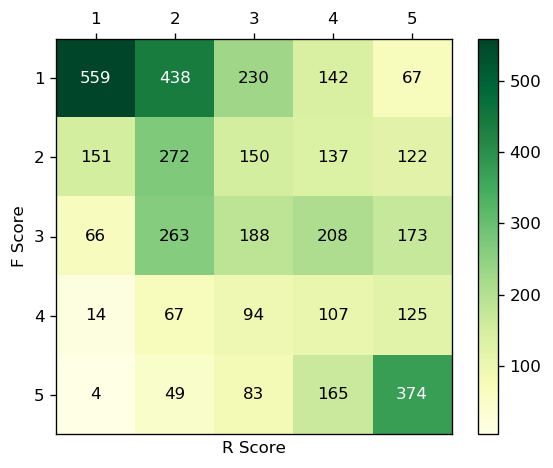

In [39]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
heatmap(rfm_count, ax = ax)
fig.tight_layout()
plt.show()

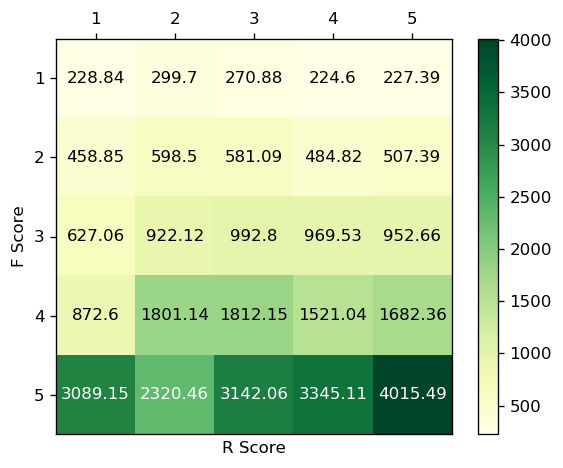

In [40]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
heatmap(rfm_median, ax = ax)
fig.tight_layout()
plt.show()

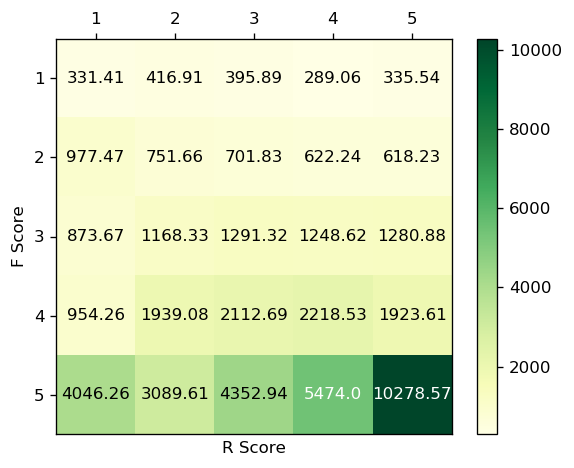

In [41]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
heatmap(rfm_mean, ax = ax)
fig.tight_layout()
plt.show()

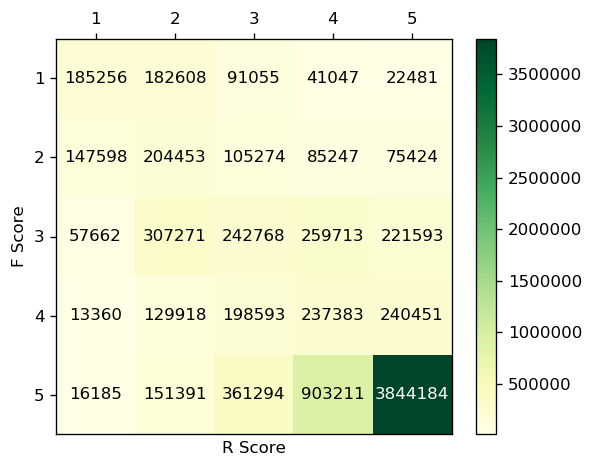

In [42]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
heatmap(rfm_sum, ax = ax)
fig.tight_layout()
plt.show()

### Short Summary:
1. High-frequency buyers (especially F-score = 5, frequency > 6/year) contribute the most to the company.
2. High frequency and most recent buyers (high F and R scores) are the ones we should definitely keep.
3. Medium Frequency (F-score = 3) are the groups we want to save (give incentives), especially for those ones who have R-score > 2.
4. The number of new customers is quite low, so the company should lunch some customer acquisition campaigns.
5. There are quite some low frequency and low recency score buyers, which means the customers may lose interest in the website or products. The company should dive deep to investigate and save this group because new customer acquisitions are expensive.

### Assign Customer Segmentation based on RFM Scores

It might not be practical to work on 5x5x5 = 125 RFM group individually. Some groups are too small, so it is hard for marketers to work on too many groups. 
Therefore, we combine some of the groups based on their RFM properties. We further assign customer segmentation for marketing purposes to give the marketers a clear goal to work on.


#### Segment Description
- **VIPs**: For those whose recent purchases are within 180 days and have bought more than 5 times in a year.
- **Potential loyalists**: For those whose recent purchases are within 180 days and have bought 3-4 times in a year.
- **Need to focus**: For those who have bought only 2 times in the past year.
- **Good old friends**: For those who have bought more than 3 times didn't purchase within 180 days.
- **New customers**: For those who have only purchased once and their recent purchase is less than 30 days.
- **Hibernating**: For those who have only purchased once, and their recent purchase has been more than 30 days.

#### Actions
- **VIPs**: Keep them happy (at any cost).
- **Potential loyalists**: Should give incentives to increase their tendency to buy more times on the website.
- **Need to focus**: They have moderate monetary contributions, but the marketer should turn them in the potential groups ASAP; otherwise, they may turn to hibernate.
- **Good old friends**: They were loyal, but it seems we are losing them. Give them incentives to recall their good memories (recommendation comes in because we have their purchase history) and make them have a recent purchase.
- **New customers**: Make them want to purchase the second time; otherwise, they'll go hibernating.
- **Hibernating**: We don't know them much, and they didn't purchase within a month. We need to guess to motivate them to buy another time. 


#### RFM Group
- **VIPs**: 25x, 35x, 45x, 55x, 24x, 34x, 44x, 54x, where x = 1...5
- **Potential loyalists**: 23x, 33x, 43x, 53x, where x = 1...5
- **Need to focus**: 12x, 22x, 32x, 42x, 52x, where x = 1...5
- **Good old frends**: 13x, 14x, 15x, where x = 1...5
- **New customers**: 41x, 51x, where x = 1...5 
- **Hibernating**: 11x, 21x, 31x, where x = 1...5  

### Let's see how it becomes after we reduced segments from 5x5x5 RFM groups down to 6 marketing gruops  

In [43]:
segmentation = {
    r'[2-5][4-5]': 'VIPs',
    r'[2-5]3': 'Potential loyalists',
    r'[1-5]2': 'Need to focus',
    r'1[3-5]': 'Good old frends',
    r'[4-5]1': 'New customers',
    r'[1-3]1': 'Hibernating',
}

In [44]:
rfm['Segment'] = rfm['R_score'] * 10 + rfm['F_score']
rfm['Segment'] = rfm['Segment'].astype(str)

In [45]:
rfm['Segment'] = rfm['Segment'].replace(segmentation, regex=True)
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,Segment
CustomerID,,,,,,,,
12347,3,7,4310.00,5,5,5,555,VIPs
12348,76,4,1437.24,2,3,4,234,Potential loyalists
12349,19,1,1457.55,4,1,4,414,New customers
12350,311,1,294.40,1,1,2,112,Hibernating
12352,37,5,1125.28,3,4,4,344,VIPs


In [46]:
rfm_segment = rfm.groupby('Segment').agg({'Recency': ['mean', 'median'], 
                                          'Frequency': ['mean', 'median'], 
                                          'Monetary': ['mean', 'median', 'sum', 'count']}).round(0).astype(int)
rfm_segment

Recency        Frequency        Monetary                  \
                       mean median      mean median     mean median      sum   
Segment                                                                        
Good old frends         228    214         4      3     1038    689    87207   
Hibernating             169    163         1      1      374    262   458919   
Need to focus            93     62         2      2      743    542   617996   
New customers            18     19         1      1      304    227    63528   
Potential loyalists      50     34         3      3     1240    970  1031344   
VIPs                     26     16        11      8     5702   2605  6066425   

                           
                    count  
Segment                    
Good old frends        84  
Hibernating          1227  
Need to focus         832  
New customers         209  
Potential loyalists   832  
VIPs                 1064

In [47]:
segment_counts = rfm_segment['Monetary']['count'].sort_values(ascending = True)
segment_counts

Segment
Good old frends          84
New customers           209
Need to focus           832
Potential loyalists     832
VIPs                   1064
Hibernating            1227
Name: count, dtype: int32

In [48]:
segment_monetary_sum = rfm_segment['Monetary']['sum'].sort_values(ascending = True)
segment_monetary_sum

Segment
New customers            63528
Good old frends          87207
Hibernating             458919
Need to focus           617996
Potential loyalists    1031344
VIPs                   6066425
Name: sum, dtype: int32

In [49]:
def hbar(data):
    
    num_of_segment = len(data)
    
    ax.set_frame_on(False)
    ax.set_yticks(range(num_of_segment))
    ax.set_yticklabels(data.index)

    bars = ax.barh(range(num_of_segment), data, color='silver')

    for i, bar in enumerate(bars):
            value = bar.get_width()
            if data.index[i] in ['VIPs']:
                bar.set_color('firebrick')
            ax.text(value,
                    bar.get_y() + bar.get_height()/2,
                    '{:,} ({:}%)'.format(int(value),int(value*100/data.sum())),
                    va='center',
                    ha='left')

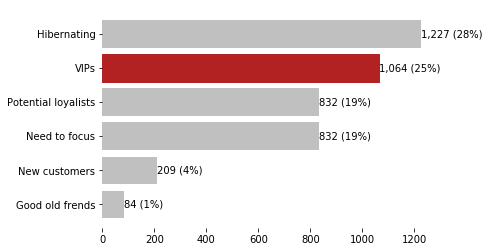

In [50]:
fig, ax = plt.subplots()
hbar(segment_counts)
plt.show()

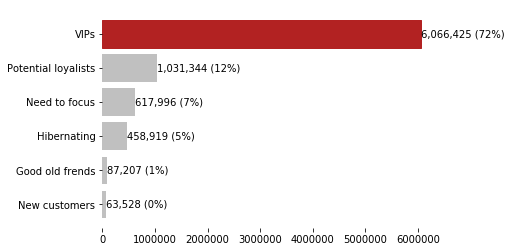

In [51]:
fig, ax = plt.subplots()
hbar(segment_monetary_sum)
plt.show()

#### Short Summary:
- VIPs are the champian, which contributes the most, but it only contributes 25% of our total customers.
- Hibernating group has a lot of people (28%). Although they didn't make any recent purchase within 180 days, it accumulated moderate income. However, since we don't know them much, it's better to investigate why they only purchased once and left.
- We don't see many new customers joining in (4%), so the customer base is relatively stable.
- It's good to see we don't have too many people in the "Good old friends" group, which means those who purchased more than three times tend to stay and keep buying within 180 days cycle.

### Let's take a look at what RFM segment are the interested CustomerID (15344, 12433, 17841) in?

In [52]:
rfm.loc[15344]

Recency                        1
Frequency                      3
Monetary                  476.58
R_score                        5
F_score                        3
M_score                        2
RFM_score                    532
Segment      Potential loyalists
Name: 15344, dtype: object

In [53]:
rfm.loc[12433]

Recency            1
Frequency          7
Monetary     13375.9
R_score            5
F_score            5
M_score            5
RFM_score        555
Segment         VIPs
Name: 12433, dtype: object

In [54]:
rfm.loc[17841]

Recency            2
Frequency        124
Monetary     37553.1
R_score            5
F_score            5
M_score            5
RFM_score        555
Segment         VIPs
Name: 17841, dtype: object

## Possible Improvements

1. RFM offers an intuitive way for segmentation, i.e., recency, frequency, and monetary values of the customers, which is easy to interpret by marketers. Marketers may use other techniques in customer segmentation such as K-means clustering, random forest. However, they are computationally expensive and hard to update the model on the fly. Therefore, for simplicity, the RFM model is still powerful in most cases.
2. The models can be more complex if we have more data, such as users' demographic data. Then, demographic, psychographic, behavioral, and geographic segmentation can come into play.
3. If we can run campaigns by preset AI, then we can have granular segmentation. Otherwise, we want to keep the numbers of the segments that can be run and controlled by marketers. 

# (2) Recommendation

Collaborative filtering (CF) is taking users' ratings to catalog items (implicitly or explicitly). The basic assumption of collaborative filtering is that customers who had similar tastes in the past will have similar tastes in the future.

Since we don't have the ratings or likes in this data set, instead of using `explicit collaborative filtering`, we need to use `implicit collaborative filtering`. `Implicit collaborative filtering` uses data with non-obvious features, such as clicks, views, or purchases, which is the case of this dataset.

Ref: "Collaborative Filtering for Implicit Feedback Datasets" by Hu, Koren, and Volinsky.

In [55]:
# The purchase quantity represents the confidence of preference.
rec_data = df_keep_no_CustomerID.groupby(['CustomerID','StockCode','Description'], as_index = False).agg({'Quantity': 'sum'})
rec_data['CustomerID'] = rec_data['CustomerID'].astype("category")
rec_data['StockCode'] = rec_data['StockCode'].astype("category")
rec_data['user'] = rec_data['CustomerID'].cat.codes
rec_data['item'] = rec_data['StockCode'].cat.codes

# Get unique customers
users = list(np.sort(rec_data['CustomerID'].unique()))

# Create Sparse Matrix to save memeories (because most cells are empty)
rec_sparse_item_user = scipy.sparse.csr_matrix((rec_data['Quantity'], (rec_data['item'], rec_data['user'])))

In [56]:
rec_data.head()

,CustomerID,StockCode,Description,Quantity,user,item
0,12347,16008,SMALL FOLDING SCISSOR(POINTED EDGE),24,0,11
1,12347,17021,NAMASTE SWAGAT INCENSE,36,0,38
2,12347,20665,RED RETROSPOT PURSE,6,0,60
3,12347,20719,WOODLAND CHARLOTTE BAG,40,0,96
4,12347,20780,BLACK EAR MUFF HEADPHONES,12,0,136


In [57]:
# Sparsity
num_of_possible_interaction = np.prod(rec_sparse_item_user.shape)
num_of_interactions = len(rec_sparse_item_user.nonzero()[0])
print("sparsity = ", 1 - num_of_interactions / num_of_possible_interaction)

sparsity =  0.9821996136270457


### Use `implicit` to build a collaborative filtering model

Ben Frederickson created `implicit` library (https://github.com/benfred/implicit) for implicit collaborative filtering.

The code reports the top 10 recommendation items.

In [58]:
import os
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1

In [59]:
# Initialize the AlternatingLeastSquares (ALS) model
model = implicit.als.AlternatingLeastSquares(factors = 20, regularization = 0.1, iterations = 50)

# Calculate the confidence by multiplying it by alpha value
# http://yifanhu.net/PUB/cf.pdf
alpha = 15
rec_conf = (rec_sparse_item_user * alpha).astype('double')

# Fit the model
model.fit(rec_conf)

100%|████████████████████████████████████████████████████████████████████████████████| 50.0/50 [00:05<00:00,  9.09it/s]


In [60]:
# helper functions - cannot move places because they need rec_date, model ready

def get_rec_items(user_id):
    # recommend items for a user
    user_items = rec_sparse_item_user.T.tocsr()
    recommendations = model.recommend(users.index(user_id), user_items)
    
    rec_items = [i[0] for i in recommendations]
    
    descriptions = []
    
    for i in rec_items:
        descriptions.extend(rec_data[rec_data['item'] == i]['Description'].astype('str').unique())

    return descriptions
    
def get_previous_items(user_id):
    return rec_data[rec_data['user'] == users.index(user_id)]['Description'].astype('str').unique().tolist()

def is_rec_in_previous_items(user_id):
    # Recommendation items are not in the previous purchase list
    return set(get_rec_items(user_id)).issubset(get_previous_items(user_id))

### 1. Study on CustomerID = 17841

In [61]:
get_rec_items(17841)

['IVORY LOVE BIRD CANDLE',
 'TEATIME GEL PENS ASST',
 'TOAST ITS - HAPPY BIRTHDAY',
 'EDWARDIAN PARASOL PINK',
 'RECYCLED ACAPULCO MAT PINK',
 'SET OF 2 ROUND TINS CAMEMBERT',
 'SET OF 4 ROSE BOTANICAL CANDLES',
 'CLAM SHELL SMALL',
 'BLUE POLKADOT KIDS BAG',
 'RETRO PLASTIC DAISY TRAY']

In [62]:
len(get_previous_items(17841))

1321

In [63]:
#get_previous_items(17841) # list is long, so commentted it

In [64]:
is_rec_in_previous_items(17841)

False

#### Summary of CustomerID = 17841

It seems this customer is interested in cooking, parties, and household/office kinds of stuff. This customer bought 1321 different items previously, and some of the items are pretty similar but with different styles. It seems like the customer is a reseller. The recommendation pattern is not obvious because the purchase history is not obvious too.

- Customer persona: a reseller (buy things on the website and sell to others)

### 2. Study on CustomerID = 12433

In [65]:
get_rec_items(12433)

['FRIDGE MAGNETS LA VIE EN ROSE',
 'FRIDGE MAGNETS LES ENFANTS ASSORTED',
 'ASSORTED BOTTLE TOP MAGNETS',
 'SET OF 5 MINI GROCERY MAGNETS',
 'SET OF 4 JAM JAR MAGNETS',
 'RED DINER WALL CLOCK',
 'KINGS CHOICE MUG',
 'RETRO COFFEE MUGS ASSORTED',
 'IVORY DINER WALL CLOCK',
 'SET OF 5 LUCKY CAT MAGNETS']

In [66]:
get_previous_items(12433)

['PAPER POCKET TRAVELING FAN',
 'ASSORTED COLOURS SILK FAN',
 'SMALL FOLDING SCISSOR(POINTED EDGE)',
 'SMALL CHINESE STYLE SCISSOR',
 'LARGE CHINESE STYLE SCISSOR',
 'PORCELAIN BUDAH INCENSE HOLDER',
 'RED RETROSPOT PURSE',
 'EDWARDIAN PARASOL RED',
 'DOORMAT RED RETROSPOT',
 'SET/5 RED RETROSPOT LID GLASS BOWLS',
 'VINTAGE BILLBOARD LOVE/HATE MUG',
 'SET/20 RED RETROSPOT PAPER NAPKINS',
 'RED RETROSPOT OVEN GLOVE',
 'RETROSPOT CHILDRENS APRON',
 'MOODY GIRL DOOR HANGER',
 'MOODY BOY DOOR HANGER',
 'TOXIC AREA DOOR HANGER',
 'BEWARE OF THE CAT METAL SIGN',
 'COOK WITH WINE METAL SIGN',
 "YOU'RE CONFUSING ME METAL SIGN",
 'GIN + TONIC DIET METAL SIGN',
 'GIN AND TONIC DIET METAL SIGN',
 'PLEASE ONE PERSON METAL SIGN',
 'PACK OF 72 RETROSPOT CAKE CASES',
 'PACK OF 72 SKULL CAKE CASES',
 'SET 3 RETROSPOT TEACOFFEESUGAR',
 'RED RETROSPOT ROUND CAKE TINS',
 'RED SPOTTY BISCUIT TIN',
 'DOOR HANGER MUM + DADS ROOM',
 'FIRST AID TIN',
 'WHITE SKULL HOT WATER BOTTLE',
 'FAWN BLUE HOT WATER BOTT

In [67]:
is_rec_in_previous_items(12433)

False

#### Summary of CustomerID = 12433

It seems this customer is interested in kitchen and household accessories. This customer has bought 222 different items, and some of the items are similar but just in different styles. The recommendations are matched with the previous orders.

- Customer persona: kitchen and household accessories resellers

### 3. Study on CustomerID = 15344

In [68]:
get_rec_items(15344)

['METAL 4 HOOK HANGER FRENCH CHATEAU',
 'LOVEBIRD HANGING DECORATION WHITE',
 'HOME SWEET HOME BLACKBOARD',
 'WOODEN PICTURE FRAME WHITE FINISH',
 'WOODEN STAR CHRISTMAS SCANDINAVIAN',
 'DOORSTOP RETROSPOT HEART',
 'REGENCY TEA PLATE GREEN',
 'PARISIENNE KEY CABINET',
 'PAINTED METAL STAR WITH HOLLY BELLS',
 'REGENCY TEA PLATE ROSES']

In [69]:
get_previous_items(15344)

['DARK BIRD HOUSE TREE DECORATION',
 'CLASSIC METAL BIRDCAGE PLANT HOLDER',
 'HOME BUILDING BLOCK WORD',
 'WALL MIRROR RECTANGLE DIAMANTE PINK',
 'REGENCY CAKESTAND 3 TIER',
 'IVORY KITCHEN SCALES',
 'GREEN REGENCY TEACUP AND SAUCER',
 'PINK REGENCY TEACUP AND SAUCER',
 'SET OF TEA COFFEE SUGAR TINS PANTRY',
 'SET OF 3 REGENCY CAKE TINS',
 'RUSTIC MIRROR WITH LACE HEART',
 'LETTER HOLDER HOME SWEET HOME',
 'PHOTO FRAME LINEN AND LACE SMALL',
 'GINGHAM RECIPE BOOK BOX',
 'METAL SIGN DROP YOUR PANTS',
 'NATURAL HANGING QUILTED HEARTS',
 'DOORMAT NEW ENGLAND',
 'DOORMAT HEARTS',
 '3 DRAWER ANTIQUE WHITE WOOD CABINET',
 'CREAM SWEETHEART MINI CHEST']

In [70]:
is_rec_in_previous_items(15344)

False

#### Summary of CustomerID = 15344

It seems this customer is interested in home decoration and some teaware/coffeeware. The recommendations are matched with the previous orders.

- Customer persona: stay-at-home-mom who pay attention to the living quality

### Other recommendations?

- It's never wrong to recommend the overall popular items!!! 

In [71]:
# top 10 item sold - don't consider the quantity sold but the number of times sold to customers
df.Description.value_counts().head(10)

REGENCY CAKESTAND 3 TIER              2012
WHITE HANGING HEART T-LIGHT HOLDER    1993
JUMBO BAG RED RETROSPOT               1632
ASSORTED COLOUR BIRD ORNAMENT         1387
PARTY BUNTING                         1359
LUNCH BAG RED RETROSPOT               1301
SET OF 3 CAKE TINS PANTRY DESIGN      1183
LUNCH BAG BLACK SKULL                 1066
LUNCH BAG SUKI DESIGN                 1062
PACK OF 72 RETROSPOT CAKE CASES       1043
Name: Description, dtype: int64

## Possible Improvements
1. The dataset contains mainly the UK region transactions. However, for the convenience of the analysis, we only consider the user purchase patterns regardless of the region. Therefore, if we have more data, region data can be considered in the model (or have different models for different regions).
2. We can have a train-test split based on time series or hide some of the purchases for each customer to evaluate the model performance or accuracy.
3. Other techniques like the ensemble method, sequence-to-sequence, or natural language processing can help decode the `Description` column. However, we need to model complexity and computational cost to perform real-time recommendations.  